In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import interpolate
import matplotlib.pyplot as plt

def load_and_interpolate_data(input_file, output_file, method='quadratic'):
    # Datei einlesen mit angepassten Spaltennamen für Day-Ahead-Daten
    df = pd.read_csv(input_file, sep=';', decimal=',')
    print(f"Originaldaten geladen: {len(df)} Einträge")
    print(df.head())
    
    # DataFrame für interpolierte Daten vorbereiten
    df_interpolated = []
    
    # Werte für Interpolation vorbereiten - Spaltenname angepasst
    values = df['Spotmarktpreis in ct/kWh'].values
    
    # Für quadratische Interpolation mindestens 3 Punkte benötigt
    if len(values) < 3:
        print("Zu wenige Datenpunkte für quadratische Interpolation!")
        return None, None, None
    
    # X-Werte (Zeitpunkte) für die 60-Minuten-Intervalle (stündlich)
    x_orig = np.arange(0, len(values) * 60, 60)
    
    # X-Werte für die 5-Minuten-Intervalle
    x_new = np.arange(0, (len(values) - 1) * 60 + 1, 5)
    
    # Interpolation durchführen
    if method == 'quadratic':
        f = interpolate.interp1d(x_orig, values, kind='quadratic', bounds_error=False, fill_value="extrapolate")
    else:
        f = interpolate.interp1d(x_orig, values, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Neue Y-Werte berechnen
    y_new = f(x_new)
    
    # Über jeden 5-Minuten-Zeitpunkt iterieren
    for i in range(len(x_new)):
        # Index des vorherigen 60-Minuten-Blocks
        orig_idx = i // 12  # 12 Fünf-Minuten-Intervalle pro Stunde
        if orig_idx >= len(df):
            break
            
        # Aktuellen Datenpunkt aus Originaldaten holen
        row = df.iloc[orig_idx]
        current_date = row['Datum']
        current_timezone = row['Zeitzone von']
        
        # Zeitpunkte berechnen (angepasst für Stunden-Format)
        dt_start = datetime.strptime(f"{current_date} {row['von']}", "%d.%m.%Y %H:%M")
        additional_minutes = (i % 12) * 5  # 12 Intervalle pro Stunde
        
        time_from = dt_start + timedelta(minutes=additional_minutes)
        time_to = time_from + timedelta(minutes=5)
        
        # Datenpunkt hinzufügen
        df_interpolated.append({
            'Datum': time_from.strftime("%d.%m.%Y"),
            'von': time_from.strftime("%H:%M"),
            'Zeitzone': current_timezone,
            'bis': time_to.strftime("%H:%M"),
            'Preis': round(y_new[i], 6)  # Mehr Dezimalstellen für ct/kWh
        })
    
    df_interpolated = df_interpolated[:-1]
    
    # In DataFrame umwandeln
    result_df = pd.DataFrame(df_interpolated)
    
    # Vollständiges Datum für Berechnung erstellen
    result_df['Volles_Datum'] = pd.to_datetime(result_df['Datum'] + ' ' + result_df['von'], format="%d.%m.%Y %H:%M")
    
    # Kalenderwoche berechnen
    result_df['Jahr'] = result_df['Volles_Datum'].dt.year
    result_df['KW'] = result_df['Volles_Datum'].dt.isocalendar().week
    result_df['Minuten'] = result_df['Volles_Datum'].dt.hour * 60 + result_df['Volles_Datum'].dt.minute
    
    # Tag von 1 bis 366 mit aufnehmen
    result_df['Tag'] = result_df['Volles_Datum'].dt.dayofyear
    
    # KW 53 für Ende des Jahres
    result_df.loc[(result_df['KW'] == 1) & (result_df['Volles_Datum'].dt.month == 12), 'KW'] = 53
    
    # Spalten neu organisieren
    result_df = result_df[['Volles_Datum', 'Jahr', 'KW', 'Tag','Minuten', 'Preis']]
    
    print(f"Interpolierte Daten erstellt: {len(result_df)} Einträge")
    print(result_df.head())
    
    # In CSV-Datei speichern
    result_df.to_csv(output_file, sep=';', decimal=',', index=False)
    print(f"Interpolierte Daten in {output_file} gespeichert.")
    
    return result_df, y_new, x_new

# Pfade festlegen
input_file = "/Users/davidsanders/Documents/GitHub/masterarbeit-flex-kpis/input/datenaufbereitung_dayahead/dayahead_2024.csv"
output_file_quadratic = "/Users/davidsanders/Documents/GitHub/masterarbeit-flex-kpis/input/datenaufbereitung_dayahead/dayahead_2024_5min.csv"

# Funktionen aufrufen
df_quad, y_quad, x_quad = load_and_interpolate_data(input_file, output_file_quadratic, method='quadratic')



Originaldaten geladen: 8785 Einträge
        Datum    von Zeitzone von    bis Zeitzone bis  \
0  01.01.2024  00:00          CET  01:00          CET   
1  01.01.2024  01:00          CET  02:00          CET   
2  01.01.2024  02:00          CET  03:00          CET   
3  01.01.2024  03:00          CET  04:00          CET   
4  01.01.2024  04:00          CET  05:00          CET   

   Spotmarktpreis in ct/kWh  
0                     0.010  
1                     0.001  
2                     0.000  
3                    -0.001  
4                    -0.003  
Interpolierte Daten erstellt: 105408 Einträge
         Volles_Datum  Jahr  KW  Tag  Minuten     Preis
0 2024-01-01 00:00:00  2024   1    1        0  0.010000
1 2024-01-01 00:05:00  2024   1    1        5  0.008894
2 2024-01-01 00:10:00  2024   1    1       10  0.007853
3 2024-01-01 00:15:00  2024   1    1       15  0.006877
4 2024-01-01 00:20:00  2024   1    1       20  0.005965
Interpolierte Daten in /Users/davidsanders/Documents/GitHu

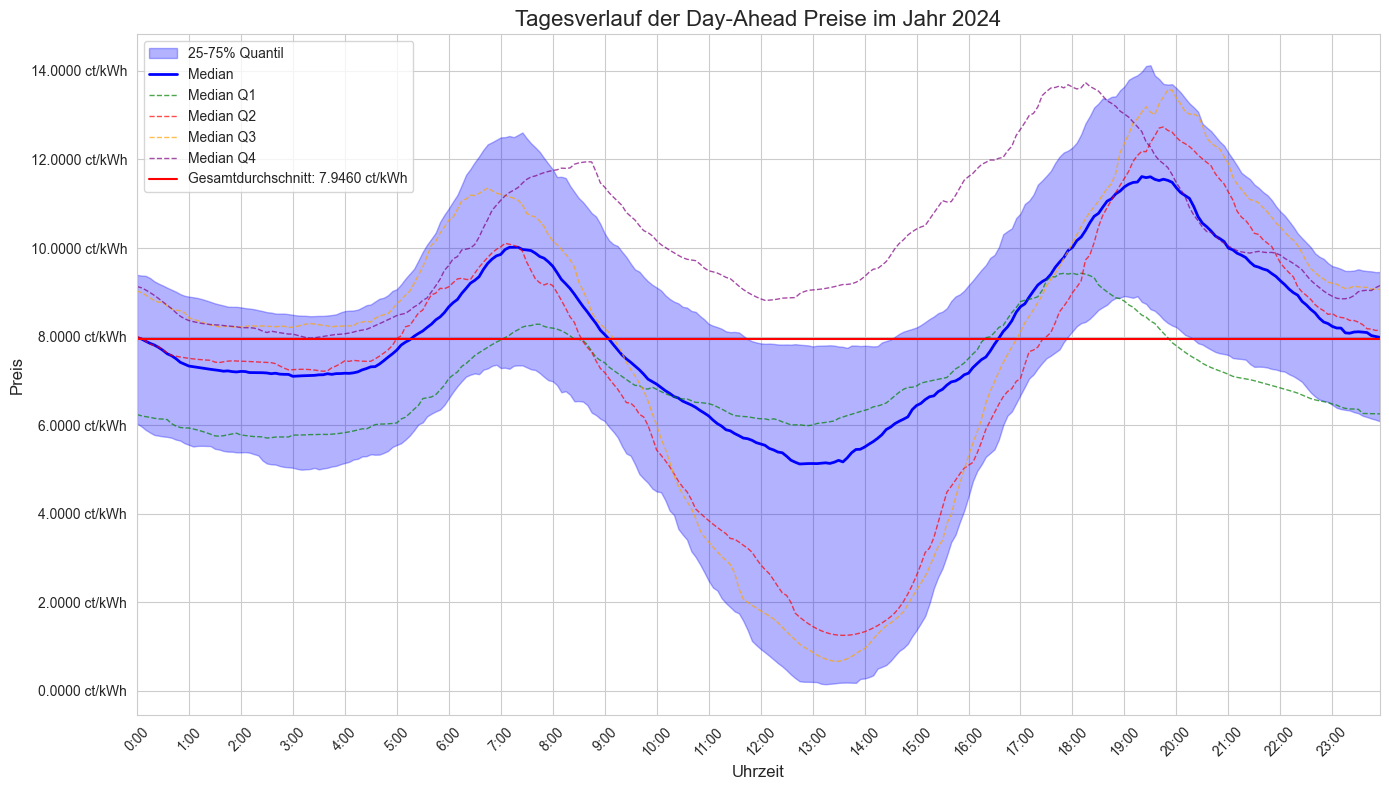

Statistiken des Preisverlaufs:
Durchschnittlicher Median: 8.018553 ct/kWh
Durchschnittliches Q25: 5.291016 ct/kWh
Durchschnittliches Q75: 10.005687 ct/kWh
Gesamtminimum: -14.019436 ct/kWh
Gesamtmaximum: 209.681000 ct/kWh


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Wir nehmen an, dass df_quad bereits geladen ist
# Falls nicht, laden wir die Daten
try:
    df = df_quad
except NameError:
    df = pd.read_csv("/Users/davidsanders/Documents/GitHub/masterarbeit-flex-kpis/input/datenaufbereitung_dayahead/dayahead_2024_5min.csv", 
                    sep=';', decimal=',')

# Sicherstellen, dass 'Volles_Datum' als Datetime vorliegt
if not pd.api.types.is_datetime64_any_dtype(df['Volles_Datum']):
    df['Volles_Datum'] = pd.to_datetime(df['Volles_Datum'])

# Quartalsweise Median berechnen
df['Quartal'] = df['Volles_Datum'].dt.to_period('Q')

df_Q1 = df[df['Quartal'] == '2024Q1']
grouped_data_Q1 = df_Q1.groupby('Minuten')['Preis']

df_Q2 = df[df['Quartal'] == '2024Q2']
grouped_data_Q2 = df_Q2.groupby('Minuten')['Preis']

df_Q3 = df[df['Quartal'] == '2024Q3']
grouped_data_Q3 = df_Q3.groupby('Minuten')['Preis']

df_Q4 = df[df['Quartal'] == '2024Q4']
grouped_data_Q4 = df_Q4.groupby('Minuten')['Preis']



# Daten nach Minuten des Tages gruppieren (0-1435)
grouped_data = df.groupby('Minuten')['Preis']
durchschnitt = df['Preis'].mean()

# Statistiken berechnen
stats = pd.DataFrame({
    'Median': grouped_data.median(),
    'Q25': grouped_data.quantile(0.25),
    'Q75': grouped_data.quantile(0.75),
    'Min': grouped_data.min(),
    'Max': grouped_data.max(),
    'Median_Q1': grouped_data_Q1.median(),
    'Median_Q2': grouped_data_Q2.median(),
    'Median_Q3': grouped_data_Q3.median(),
    'Median_Q4': grouped_data_Q4.median()
})

stats.to_csv("/Users/davidsanders/Documents/GitHub/masterarbeit-flex-kpis/input/datenaufbereitung_dayahead/dayahead_2024_stats.csv", sep=';', decimal=',')

# Diagramm erstellen
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Füllfläche für Bereich zwischen Q25 und Q75
plt.fill_between(stats.index, stats['Q25'], stats['Q75'], 
                alpha=0.3, color='blue', label='25-75% Quantil')

# Linien für Median, Min und Max
plt.plot(stats.index, stats['Median'], color='blue', linewidth=2, label='Median')
plt.plot(stats.index, stats['Median_Q1'], color='green', linewidth=1, linestyle='--', alpha=0.7, label='Median Q1')
plt.plot(stats.index, stats['Median_Q2'], color='red', linewidth=1, linestyle='--', alpha=0.7, label='Median Q2')
plt.plot(stats.index, stats['Median_Q3'], color='orange', linewidth=1, linestyle='--', alpha=0.7, label='Median Q3')
plt.plot(stats.index, stats['Median_Q4'], color='purple', linewidth=1, linestyle='--', alpha=0.7, label='Median Q4')
# plt.plot(stats.index, stats['Min'], color='red', linewidth=1, linestyle='--', alpha=0.7, label='Minimum')
# plt.plot(stats.index, stats['Max'], color='green', linewidth=1, linestyle='--', alpha=0.7, label='Maximum')
# plt.axhline(y=durchschnitt, color='red', linestyle='-', linewidth=1.5, 
#            label=f'Gesamtdurchschnitt: {durchschnitt:.4f} ct/kWh')

# X-Achse anpassen (stündlich)
hour_ticks = np.arange(0, 1440, 60)
hour_labels = [f"{h}:00" for h in range(24)]
plt.xticks(hour_ticks, hour_labels, rotation=45)

# Formatierung der Y-Achse mit ct/kWh
def ct_formatter(x, pos):
    return f"{x:.4f} ct/kWh"

plt.gca().yaxis.set_major_formatter(FuncFormatter(ct_formatter))

# Titel und Beschriftungen
plt.title('Tagesverlauf der Day-Ahead Preise im Jahr 2024', fontsize=16)
plt.xlabel('Uhrzeit', fontsize=12)
plt.ylabel('Preis', fontsize=12)
plt.legend(loc='best')

# Diagramm straffen und Grenzen setzen
plt.tight_layout()
plt.xlim(0, 1435)

# Diagramm anzeigen
plt.show()

# Statistiken ausgeben
print("Statistiken des Preisverlaufs:")
print(f"Durchschnittlicher Median: {stats['Median'].mean():.6f} ct/kWh")
print(f"Durchschnittliches Q25: {stats['Q25'].mean():.6f} ct/kWh")
print(f"Durchschnittliches Q75: {stats['Q75'].mean():.6f} ct/kWh")
print(f"Gesamtminimum: {stats['Min'].min():.6f} ct/kWh")
print(f"Gesamtmaximum: {stats['Max'].max():.6f} ct/kWh")

In [2]:
if y_quad is not None:
    # Visualisierung der ersten 24 Stunden (288 5-Minuten-Intervalle)
    # Originaldaten
    
    # Datum eingeben
    datum = "27.06.2024"

    # Datum in datetime-Objekt umwandeln
    datum_obj = datetime.strptime(datum, "%d.%m.%Y")

    # Tag im Jahr berechnen (ausgehend von 0)
    tag = datum_obj.timetuple().tm_yday - 1
    

    df_orig = pd.read_csv(input_file, sep=';', decimal=',')
    x_orig = np.arange(0, 24 * 60, 60)[0:24]
    y_orig = df_orig['Spotmarktpreis in ct/kWh'].values[tag*24:(tag+1)*24]  # Erste 24 Stunden

    plt.figure(figsize=(15, 8))

    # Plot der ersten 24 Stunden zum besseren Vergleich
    plt.plot(x_orig, y_orig, 'ro', label='Original Stundendaten', markersize=8)
    plt.plot(x_quad[:288], y_quad[tag*288:(tag+1)*288], 'b-', label='Quadratische Interpolation', linewidth=2)

    plt.title('Day-Ahead Preise: Quadratische Interpolation (24h)')
    plt.xlabel('Zeit (Minuten seit Beginn)')
    plt.ylabel('Preis (ct/kWh)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

NameError: name 'y_quad' is not defined

In [ ]:
# Calculate the mean price
mean_price = df_quad['Preis'].mean()
print(f"Mean Price: {mean_price}")

# Find the row with the maximum price
max_price_row = df_quad[df_quad['Preis'] == df_quad['Preis'].max()]
print(max_price_row)

Mean Price: 7.946002124127202
             Volles_Datum  Jahr  KW  Tag    Preis
51036 2024-06-26 06:00:00  2024  26  178  209.681
